In [1]:
from loader import get_nn_patients
from helpers import *

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical #hot-encoding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score

from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate

### Preparing the data
Important observations:
data for a given group (train or test) must be given to CNN into a single three-dimensional NumPy array, where the dimensions of the array are [samples, time steps, features], where sample: one input example that has 1 or more time steps with one or more features at each time step; time steps: one part of a single input example that has one or more features; feature: one of possible many observations for a given time step.


In [43]:
x, y, _, _= get_nn_patients()
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.30, shuffle = False, stratify = None)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((35, 857, 2), (15, 857, 2), (35, 857), (15, 857))

In [44]:
train_size, test_size = x_tr.shape[0] * x_tr.shape[1], x_te.shape[0] * x_te.shape[1]
trainX = x_tr.reshape(train_size,1,2)
trainy = y_tr.reshape(train_size)
testX = x_te.reshape(test_size,1,2)
y_te = y_te.reshape(test_size)

trainy = to_categorical(trainy)
testy = to_categorical(y_te)

trainX.shape, trainy.shape, testX.shape, testy.shape

((29995, 1, 2), (29995, 4), (12855, 1, 2), (12855, 4))

trainX = trainX.reshape(857,34,2)
trainy = trainy[1,:].reshape(857)
testX = testX.reshape(857,16,2)
testy = testy[1,:].reshape(857)

In [47]:
# summarize scores
def summarize_result(true, preds):
    print(classification_report(true,preds))
    print("Balanced accuracy:", balanced_accuracy_score(true,preds))
    print("Accuracy:",accuracy_score(true,preds))
    plot_conf_matrix(preds, true, normalize = True)

### Fitting the CNN model 
We will define the model as having two 1D CNN layers, followed by a dropout layer for regularization, then a pooling layer. It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/4 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

In [7]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    print(model.summary())
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)

# run the experiment
run_experiment()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 1, 64)             448       
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 1, 64)          

 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_44 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 1, 64)             0         
                                                                 
 flatten_14 (Flatten)        (None, 64)                0         
          

                                                                 
 conv1d_56 (Conv1D)          (None, 1, 64)             12352     
                                                                 
 max_pooling1d_56 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 1, 64)             0         
                                                                 
 flatten_18 (Flatten)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 100)               6500      
                                                                 
 dense_37 (Dense)            (None, 4)                 404       
                                                                 
Total params: 32,056
Trainable params: 32,056
Non-trainable params: 0
______

### Tuning the number of filters

>p=8 #1: 46.908
>p=8 #2: 47.694
>p=8 #3: 61.431
>p=8 #4: 64.761
>p=8 #5: 44.629
>p=8 #6: 64.761
>p=8 #7: 64.761
>p=8 #8: 58.366
>p=8 #9: 61.431
>p=8 #10: 64.761
>p=16 #1: 64.846
>p=16 #2: 64.216
>p=16 #3: 64.761
>p=16 #4: 64.846
>p=16 #5: 64.761
>p=16 #6: 56.912
>p=16 #7: 64.597
>p=16 #8: 64.846
>p=16 #9: 64.846
>p=16 #10: 64.846
>p=32 #1: 61.898
>p=32 #2: 64.683
>p=32 #3: 64.846
>p=32 #4: 64.683
>p=32 #5: 64.683
>p=32 #6: 64.683
>p=32 #7: 64.683
>p=32 #8: 64.683
>p=32 #9: 64.846
>p=32 #10: 64.846
>p=64 #1: 67.631
>p=64 #2: 67.468
>p=64 #3: 67.203
>p=64 #4: 67.242
>p=64 #5: 67.242
>p=64 #6: 68.012
>p=64 #7: 68.012
>p=64 #8: 65.228
>p=64 #9: 66.698
>p=64 #10: 66.698
>p=128 #1: 67.468
>p=128 #2: 65.251
>p=128 #3: 68.012
>p=128 #4: 66.659
>p=128 #5: 66.659
>p=128 #6: 68.012
>p=128 #7: 66.659
>p=128 #8: 67.203
>p=128 #9: 66.659
>p=128 #10: 67.203
>p=256 #1: 67.468
>p=256 #2: 66.659
>p=256 #3: 66.659
>p=256 #4: 66.278
>p=256 #5: 66.659
>p=256 #6: 67.203
>p=256 #7: 66.659
>p=256 #8: 64.442
>

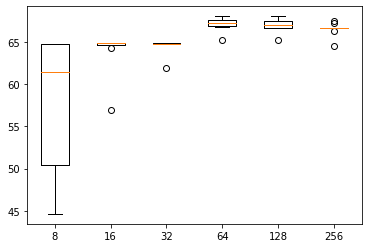

In [8]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = "same"))
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', padding = "same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# run an experiment
def run_experiment(params, repeats=10):

    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

### Tuning size of kernel

>p=2 #1: 67.203
>p=2 #2: 62.466
>p=2 #3: 66.698
>p=2 #4: 68.012
>p=2 #5: 62.466
>p=2 #6: 66.659
>p=2 #7: 66.698
>p=2 #8: 64.683
>p=2 #9: 64.683
>p=2 #10: 66.698
>p=3 #1: 66.698
>p=3 #2: 64.481
>p=3 #3: 65.228
>p=3 #4: 62.466
>p=3 #5: 64.683
>p=3 #6: 67.468
>p=3 #7: 64.683
>p=3 #8: 67.468
>p=3 #9: 64.683
>p=3 #10: 62.466
>p=5 #1: 66.698
>p=5 #2: 67.468
>p=5 #3: 66.698
>p=5 #4: 65.228
>p=5 #5: 68.012
>p=5 #6: 64.302
>p=5 #7: 67.468
>p=5 #8: 66.698
>p=5 #9: 64.683
>p=5 #10: 65.228
>p=7 #1: 64.683
>p=7 #2: 62.466
>p=7 #3: 65.795
>p=7 #4: 65.228
>p=7 #5: 67.242
>p=7 #6: 66.698
>p=7 #7: 65.228
>p=7 #8: 66.698
>p=7 #9: 61.898
>p=7 #10: 68.012
>p=11 #1: 66.317
>p=11 #2: 68.012
>p=11 #3: 68.012
>p=11 #4: 61.517
>p=11 #5: 64.481
>p=11 #6: 64.846
>p=11 #7: 67.468
>p=11 #8: 61.898
>p=11 #9: 67.242
>p=11 #10: 66.861
[[67.2034204006195, 62.46596574783325, 66.69778227806091, 68.01244616508484, 62.46596574783325, 66.65889024734497, 66.69778227806091, 64.68300223350525, 64.68300223350525, 66.6977822780

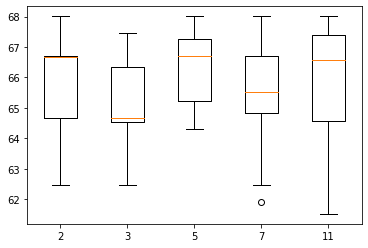

In [9]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
    verbose, epochs, batch_size = 0, 15, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features), padding = "same"))
    model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', padding = "same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_kernel.png')

# run an experiment
def run_experiment(params, repeats=10):

    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

### Running the CNN with the tuned parameters, filter = 64, kernel size = 5

402/402 [==============================] - 0s 708us/step
>#1: 67.468
402/402 [==============================] - 0s 688us/step
>#2: 64.846
402/402 [==============================] - 0s 696us/step
>#3: 64.302
402/402 [==============================] - 0s 741us/step
>#4: 64.683
402/402 [==============================] - 0s 719us/step
>#5: 64.683
402/402 [==============================] - 0s 673us/step
>#6: 67.242
402/402 [==============================] - 0s 684us/step
>#7: 66.698
402/402 [==============================] - 0s 693us/step
>#8: 67.468
402/402 [==============================] - 0s 690us/step


INFO:tensorflow:Assets written to: best_model_0.6801244616508484/assets


INFO:tensorflow:Assets written to: best_model_0.6801244616508484/assets


>#9: 68.012
402/402 [==============================] - 0s 672us/step
>#10: 64.683
              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      3639
         1.0       0.63      0.68      0.65      1606
         2.0       0.69      0.72      0.70      5977
         3.0       0.61      0.55      0.58      1633

    accuracy                           0.68     12855
   macro avg       0.66      0.66      0.66     12855
weighted avg       0.68      0.68      0.68     12855

Balanced accuracy: 0.6562619456847416
Accuracy: 0.6801244651886426
Accuracy per class: [1. 1. 1. 1.]


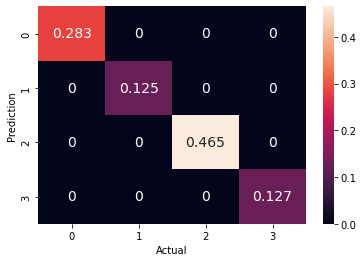

In [46]:
#fit and evaluate a model
filters = 64
kernel_size = 5
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    preds = model.predict(testX)
    classes = np.argmax(preds,axis=1)
    if accuracy > 0.68:
        model.save("best_model_" + str(accuracy))
    return classes, accuracy


# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    best_preds = []
    max_score = 0
    for r in range(repeats):
        preds, score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        if score > max_score:
            max_score = score
            best_preds = preds
    # summarize results
    summarize_result(y_te, best_preds)

# run the experiment
run_experiment()

### Multi - headed CNN

In [15]:
# multi-headed cnn

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1_1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding = "same")(inputs1)
    drop1_1 = Dropout(0.5)(conv1_1)
    conv1_2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding = "same")(inputs1)
    drop1_2 = Dropout(0.5)(conv1_2)
    flat1 = Flatten()(drop1_2)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2_1 = Conv1D(filters=128, kernel_size=7, activation='relu', padding = "same")(inputs2)
    drop2_1 = Dropout(0.5)(conv2_1)
    conv2_2 = Conv1D(filters=128, kernel_size=7, activation='relu', padding = "same")(inputs2)
    drop2_2 = Dropout(0.5)(conv2_2)
    flat2 = Flatten()(drop2_2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3_1 = Conv1D(filters=256, kernel_size=11, activation='relu', padding = "same")(inputs3)
    drop3_1 = Dropout(0.5)(conv3_1)
    conv3_2 = Conv1D(filters=256, kernel_size=11, activation='relu', padding = "same")(inputs3)
    drop3_2 = Dropout(0.5)(conv3_2)
    flat3 = Flatten()(drop3_2)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    preds = model.predict(testX)
    classes = np.argmax(preds,axis=1)
    return classes, accuracy

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    best_preds = []
    max_score = 0
    for r in range(repeats):
        preds, score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        if score > max_score:
            max_score = score
            best_preds = preds
    # summarize results
    summarize_result(y_te, best_preds)

# run the experiment
run_experiment()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


ValueError: in user code:

    File "/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_15" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 2) dtype=float32>]


### Trying with the two different augmentation (small and big)

In [16]:
x_small, y_small, x_big, y_big = get_nn_patients(divided = True)

In [17]:
x_small.shape , x_big.shape , y_small.shape , y_big.shape

((31, 713, 2), (19, 1087, 2), (31, 713), (19, 1087))

#### CNN with small mean 

In [24]:
x, y, _, _= get_nn_patients(divided=True)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.30, random_state=42)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((21, 713, 2), (10, 713, 2), (21, 713), (10, 713))

In [25]:
train_size, test_size = x_tr.shape[0] * x_tr.shape[1], x_te.shape[0] * x_te.shape[1]
trainX = x_tr.reshape(train_size,1,2)
trainy = y_tr.reshape(train_size)
testX = x_te.reshape(test_size,1,2)
y_te = y_te.reshape(test_size)

trainy = to_categorical(trainy)
testy = to_categorical(y_te)

223/223 [==============================] - 0s 843us/step
>#1: 65.217
223/223 [==============================] - 0s 737us/step
>#2: 65.568
223/223 [==============================] - 0s 705us/step
>#3: 64.741
223/223 [==============================] - 0s 730us/step
>#4: 64.741
223/223 [==============================] - 0s 756us/step
>#5: 65.217
              precision    recall  f1-score   support

         0.0       0.79      0.64      0.71      1748
         1.0       0.58      0.28      0.38       657
         2.0       0.64      0.78      0.70      3470
         3.0       0.58      0.54      0.56      1255

    accuracy                           0.66      7130
   macro avg       0.65      0.56      0.59      7130
weighted avg       0.66      0.66      0.65      7130

Balanced accuracy: 0.5586178620873691
Accuracy: 0.655680224403927
Accuracy per class: [1. 1. 1. 1.]


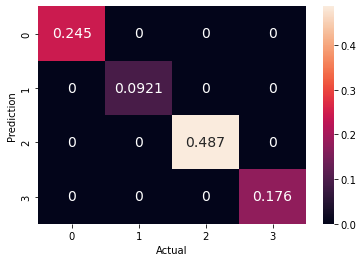

In [27]:
#fit and evaluate a model
filters = 64
kernel_size = 5
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    preds = model.predict(testX)
    classes = np.argmax(preds,axis=1)
    return classes, accuracy

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    best_preds = []
    max_score = 0
    for r in range(repeats):
        preds, score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        if score > max_score:
            max_score = score
            best_preds = preds
    # summarize results
    summarize_result(y_te, best_preds)

# run the experiment
run_experiment(repeats=5)

#### CNN with large mean

In [28]:
_, _, x, y= get_nn_patients(divided=True)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.30, random_state=42)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((13, 1087, 2), (6, 1087, 2), (13, 1087), (6, 1087))

In [30]:
train_size, test_size = x_tr.shape[0] * x_tr.shape[1], x_te.shape[0] * x_te.shape[1]
trainX = x_tr.reshape(train_size,1,2)
trainy = y_tr.reshape(train_size)
testX = x_te.reshape(test_size,1,2)
y_te = y_te.reshape(test_size)

trainy = to_categorical(trainy)
testy = to_categorical(y_te)

204/204 [==============================] - 0s 860us/step
>#1: 60.396
204/204 [==============================] - 0s 779us/step
>#2: 60.396
204/204 [==============================] - 0s 777us/step
>#3: 56.869
204/204 [==============================] - 0s 780us/step
>#4: 56.869
204/204 [==============================] - 0s 747us/step
>#5: 53.143
204/204 [==============================] - 0s 865us/step
>#6: 53.174
204/204 [==============================] - 0s 777us/step
>#7: 60.426
204/204 [==============================] - 0s 804us/step
>#8: 56.869
204/204 [==============================] - 0s 803us/step
>#9: 56.900
204/204 [==============================] - 0s 789us/step
>#10: 50.629
              precision    recall  f1-score   support

         0.0       0.50      0.37      0.43      1186
         1.0       0.55      0.61      0.58      1237
         2.0       0.61      0.71      0.66      2939
         3.0       0.75      0.57      0.65      1160

    accuracy                         

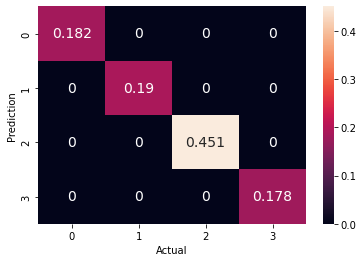

In [31]:
#fit and evaluate a model
filters = 64
kernel_size = 11
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    preds = model.predict(testX)
    classes = np.argmax(preds,axis=1)
    return classes, accuracy


# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    best_preds = []
    max_score = 0
    for r in range(repeats):
        preds, score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        if score > max_score:
            max_score = score
            best_preds = preds
    # summarize results
    summarize_result(y_te, best_preds)

# run the experiment
run_experiment()

### Raw Features

In [32]:
x, y, _, _= get_nn_patients(raw=True)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.30, random_state=42)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((35, 857, 9), (15, 857, 9), (35, 857), (15, 857))

In [33]:
x_tr, x_te = x_tr[:,:,[0,2,5]], x_te[:,:,[0,2,5]]
train_size, test_size = x_tr.shape[0] * x_tr.shape[1], x_te.shape[0] * x_te.shape[1]
trainX = x_tr.reshape(train_size,1,3)
trainy = y_tr.reshape(train_size)
testX = x_te.reshape(test_size,1,3)
y_te = y_te.reshape(test_size)

trainy = to_categorical(trainy)
testy = to_categorical(y_te)

trainX.shape, testX.shape, trainy.shape, testy.shape

((29995, 1, 3), (12855, 1, 3), (29995, 4), (12855, 4))

402/402 [==============================] - 0s 786us/step
>#1: 65.819
402/402 [==============================] - 0s 774us/step
>#2: 62.505
402/402 [==============================] - 0s 780us/step
>#3: 62.832
402/402 [==============================] - 0s 771us/step
>#4: 65.655
402/402 [==============================] - 0s 743us/step
>#5: 60.342
402/402 [==============================] - 0s 774us/step
>#6: 64.597
402/402 [==============================] - 0s 830us/step
>#7: 64.426
402/402 [==============================] - 0s 813us/step
>#8: 62.762
402/402 [==============================] - 0s 763us/step
>#9: 62.567
402/402 [==============================] - 0s 829us/step
>#10: 66.519
              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      3250
         1.0       0.63      0.58      0.60      2059
         2.0       0.67      0.72      0.69      5670
         3.0       0.64      0.54      0.58      1876

    accuracy                         

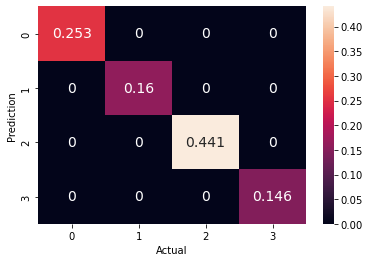

In [34]:
#fit and evaluate a model
filters = 64
kernel_size = 11
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    preds = model.predict(testX)
    classes = np.argmax(preds,axis=1)
    return classes, accuracy


# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    best_preds = []
    max_score = 0
    for r in range(repeats):
        preds, score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        if score > max_score:
            max_score = score
            best_preds = preds
    # summarize results
    summarize_result(y_te, best_preds)

# run the experiment
run_experiment()